# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project, I used Python and Keras with TensorFlow backend to classify German traffic signs.

I use the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), this dataset contains more than 50,000 images of 43 classes (German traffic signs).

I could reach a validation accuracy of 97.60% and a test accuracy of 95.46%.

### Solution Steps:
* Load The Data.
* Dataset Summary & Exploration
* Image Preprocessing
* Image Augmentation
* Design and Test Model Architecture
    * LeNet-5 Architecture
    * MiniVGGNet Architecture
    * Testing the Model Using the Test Set
* Test the Model on New Images


---
## Step 0: Load The Data

The dataset could be downloaded from [traffic-signs-data](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip). This dataset contains the following three pickle files:

* train.p: The training set.
* valid.p: The validation set.
* test.p: The testing set.

Each of the 3 pickle files contains a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

All images (features) in the dataset are alreday resized to the size of 32 x 32 pixles.

The data (train.p, test.p, valid.p) must be located in the `data` folder one level above the notebook to run the following steps!

In [6]:
# Load pickled data
import pickle
import os

training_file = '../data/train.p'
validation_file = '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


Load traffic sign names from `signnames.csv`. The names will be needed later to display the descriptive names of the traffic signs instead of the class IDs.

In [7]:
import csv
import numpy as np

# load class-ids and sign names from csv file
def load_signnames_from_csv(filename):
    rows = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)  # skip header
        for row in reader:
            class_id = row[0]
            sign_name = row[1]
            rows.append((class_id, sign_name))

    return np.array(rows)


sign_names = load_signnames_from_csv('signnames.csv')
num_classes = len(sign_names)
print('Number of classes: {}'.format(num_classes))
print()

for sign in sign_names:
    print('{:4d}: {}'.format(int(sign[0]), sign[1]))

Number of classes: 43

   0: Speed limit (20km/h)
   1: Speed limit (30km/h)
   2: Speed limit (50km/h)
   3: Speed limit (60km/h)
   4: Speed limit (70km/h)
   5: Speed limit (80km/h)
   6: End of speed limit (80km/h)
   7: Speed limit (100km/h)
   8: Speed limit (120km/h)
   9: No passing
  10: No passing for vehicles over 3.5 metric tons
  11: Right-of-way at the next intersection
  12: Priority road
  13: Yield
  14: Stop
  15: No vehicles
  16: Vehicles over 3.5 metric tons prohibited
  17: No entry
  18: General caution
  19: Dangerous curve to the left
  20: Dangerous curve to the right
  21: Double curve
  22: Bumpy road
  23: Slippery road
  24: Road narrows on the right
  25: Road work
  26: Traffic signals
  27: Pedestrians
  28: Children crossing
  29: Bicycles crossing
  30: Beware of ice/snow
  31: Wild animals crossing
  32: End of all speed and passing limits
  33: Turn right ahead
  34: Turn left ahead
  35: Ahead only
  36: Go straight or right
  37: Go straight or le

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [8]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print()
print("Image Shape: {}".format(X_train[0].shape) )


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

Image Shape: (32, 32, 3)


### Training DataSet Visualization

First, we examine how often each class is represented in the dataset. The easiest way is to use a histogram of the number of images in unique each class.

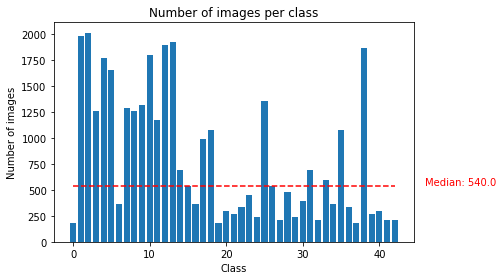


Median of images per class: 540.0


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

# histogram of class frequency
fig, ax = plt.subplots()
hist, bins = np.histogram(y_train, bins=n_classes)
center = np.array(range(0, n_classes))
median = np.median(hist)
ax.plot(bins, np.full(len(bins), median, dtype=int), '--', color='red')
ax.bar(center, hist, align='center', width=0.8)
ax.set_title("Number of images per class")
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.text(n_classes+3, median, 'Median: {}'.format(median), color='red')
fig.tight_layout()
plt.show()

print()
print('Median of images per class: {}'.format(median))

If the classes in the dataset are represented very differently, the classes that are represented more frequently are preferred in the classification. However, this should be avoided, therefore each class in the training data set should be represented by an approximately equal number of images.

The histogram above shows that classes are very differently represented, which adversely affects predictive accuracy. Normally, it would be better to supplement the weakly represented classes with more pictures until the number of pictures per class is about the same. But for that we would need a lot more pictures of traffic signs. Therefore I decided to cut the items per class of the training dataset at median number of images per classes.

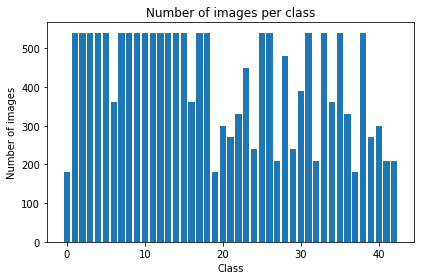

In [10]:
# cut number of images per class to the median number images per class
def equalize_images_per_class(data, labels, num_classes, threshold):
    images = []
    classes = []
    for class_id in range(0, num_classes):
        group = data[labels == class_id]
        if len(group) > threshold:
            group = group[:threshold]

        for image in group:
            images.append(image)
            classes.append(class_id)
    return np.array(images), np.array(classes)

X_train, y_train = equalize_images_per_class(X_train, y_train, num_classes, int(median))

# histogram of class frequency
fig, ax = plt.subplots()
hist, bins = np.histogram(y_train, bins=n_classes)
center = np.array(range(0, n_classes))
ax.bar(center, hist, align='center', width=0.8)
ax.set_title("Number of images per class")
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
fig.tight_layout()
plt.show()

The distribution is still not optimal, but much better than before. Unfortunately, some classes are very poorly represented, but it makes no sense to use even fewer images because as a rule of thumb you should have at least 1000 images per class to get a good trainig result.

I trained and tested the network once with and once without adjusting the number of pictures. Although I achieved better training and validation results without the adjustment, the network worked better with the alignment during the test.

Next, let's look at the pictures of the dataset. The following diagram shows ten randomly selected images of each class in the training dataset.

In [11]:
import random

def show_dataset(X, y, sign_names, columns=10):
    classes = np.unique(y)

    # show image of 10 random data points
    fig, axs = plt.subplots(len(classes), columns, figsize=(15, 120))
    fig.subplots_adjust(hspace=0.3)
    axs = axs.ravel()
    for row, class_id in enumerate(classes):
        group = X[y == class_id]
        sign_name = sign_names[class_id]
        for col in range(columns):
            image = group[random.randint(0, len(group) - 1)]
            index = row * columns + col
            axs[index].axis('off')
            axs[index].set_title(sign_name)
            if len(image.shape) == 3:
                axs[index].imshow(image)
            else:
                axs[index].imshow(image, cmap='gray')
    plt.show()

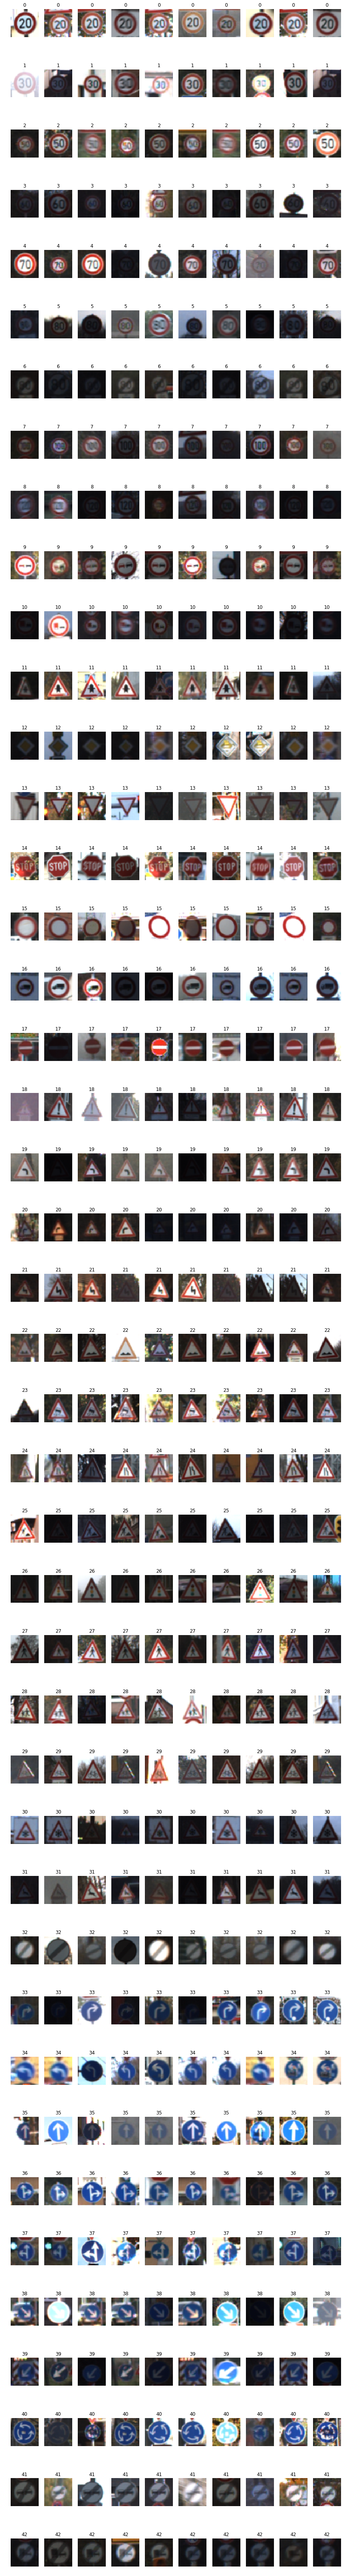

In [12]:
show_dataset(X_train, y_train, np.unique(y_train).astype(str))

----

## Step 2: Image Preprocessing

In this step I tested some preprocessing techniques like grayscaling and local histogram equalization.

I trained and tested my network with and without grayscale images respectively local histogram equalization. With grayscale images and histogram equalization, I could achieve better training results, but in the recognition of real images from the Internet I have achieved better results when I use color images. Finally I decided to use color images for this project.

### Grayscale Images

For many classification problems, the colors play little role, just shapes and edges, etc. In these cases, it may be helpful to use grayscale images instead of color images. Especially with large datasets, this speeds up the training process and can also have a positive effect on the achieved accuracy.

The following diagram shows the images of the training dataset as grayscale images.

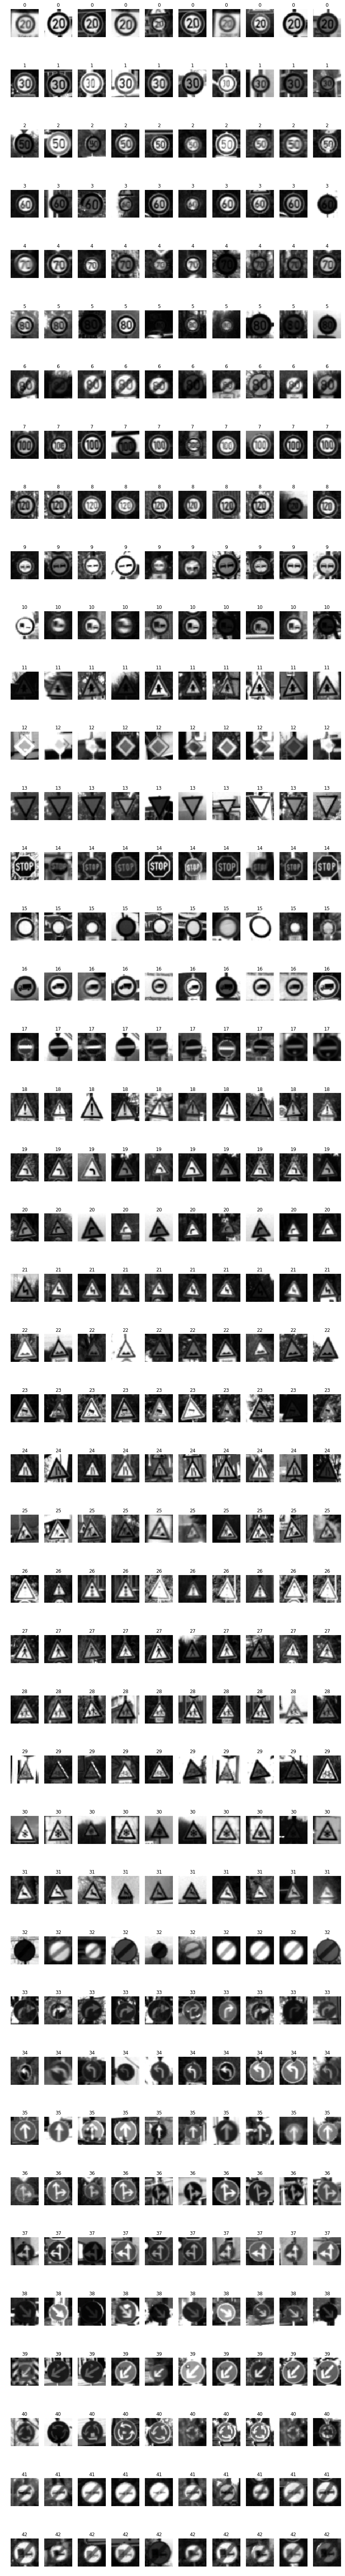

In [ ]:
import cv2

# convert images to grayscale
def to_grayscale(images):
    result = []
    for image in images:
        result.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    return np.array(result)


train_gray = to_grayscale(X_train)
show_dataset(train_gray, y_train, np.unique(y_train).astype(str))

###  Local Histogram Equalization

This technique simply distributes the most common intensity values in an image, improving low-contrast images. 

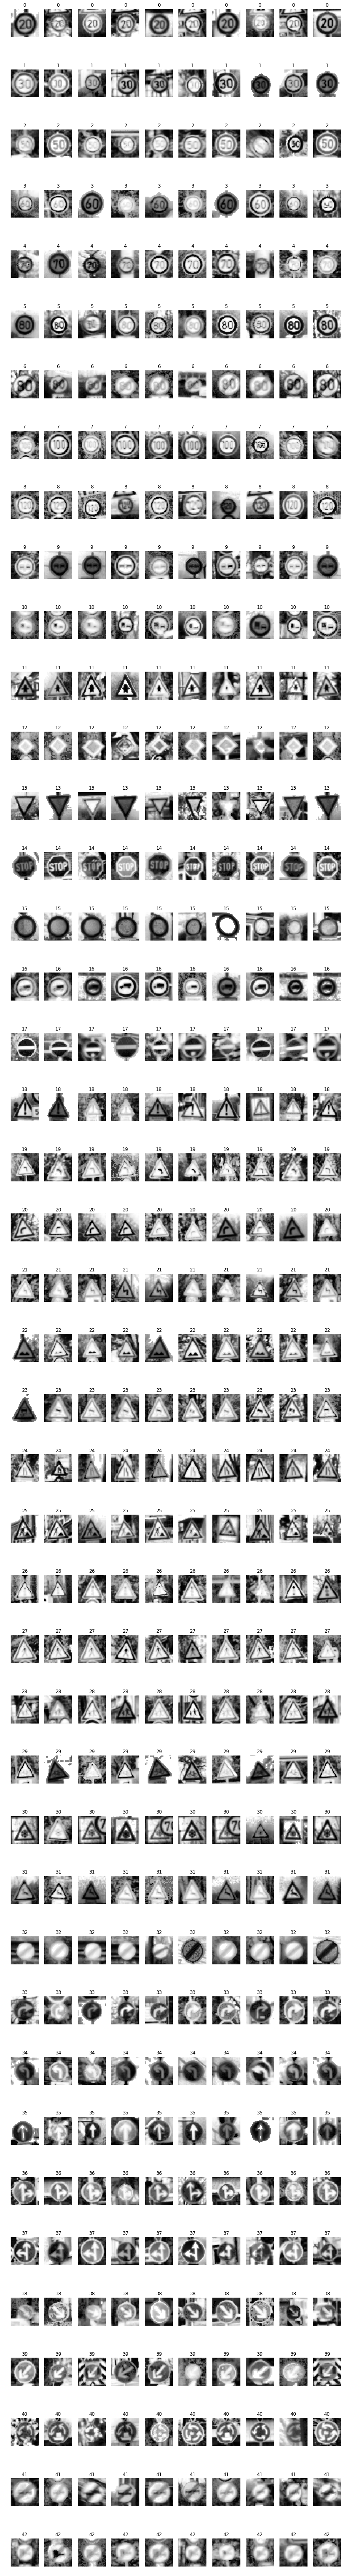

In [28]:
import skimage.morphology as morp
from skimage.filters import rank

# apply local histogram equalization
def local_histogram_equalization(image):
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

train_equalized = np.array(list(map(local_histogram_equalization, train_gray)))
show_dataset(train_equalized, y_train, np.unique(y_train).astype(str))

I have tested my network with and without grayscale images respectively histogram Equalization. With grayscale images and histogram equalization, I could easily achieve better training results, but in the recognition of real images from the Internet I have achieved better results when I use color images. So I decided to use color images for this project.

## Step 3: Image Augmentation

Data augmentation is a great technique for artificially propagating images of a dataset by duplicating existing images through random manipulations such as scaling, rotation, tilt, noise, ect.

This can be done either by hand by building an augmentation pipeline, analogous to a preprocessing pipeline, which makes the appropriate manipulations. For example, OpenVC offers numerous functions for image manipulation.

But I prefer to use ready-made libraries like `imgaug` or` augmentor`. Here the augmentation pipeline will be described declaratively, which is very clear. For this project I use `augmentor`, see https://augmentor.readthedocs.io/en/master/. The augmentor delivers already normalized images, so that the normalization by the Image Preprocessing is droped.

#### Zoom

I use random zoom between factor 0.8 and 1.2 to simulate different distances from the camera to the signs. 

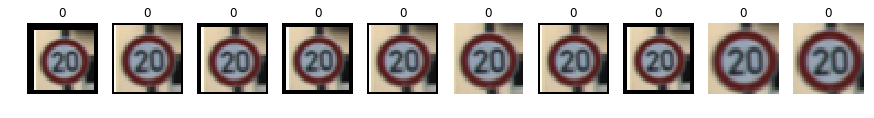

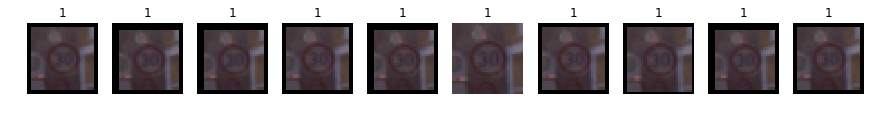

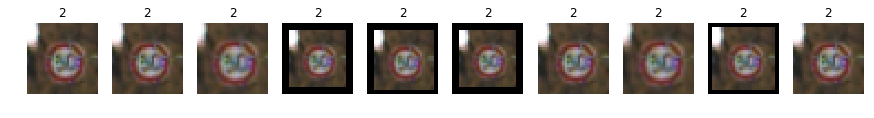

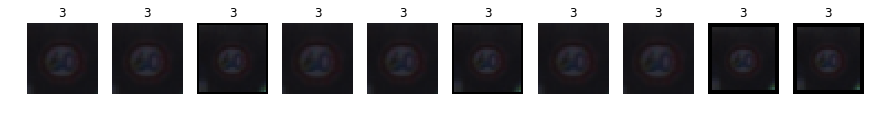

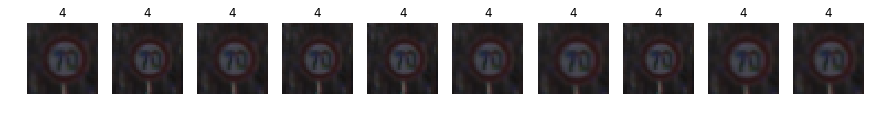

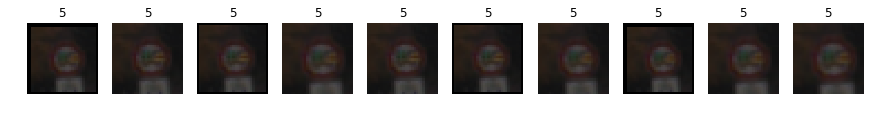

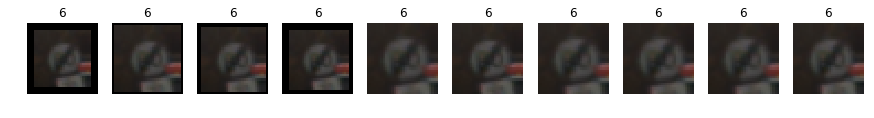

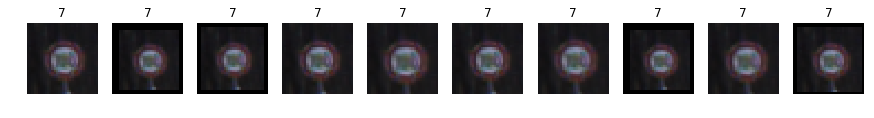

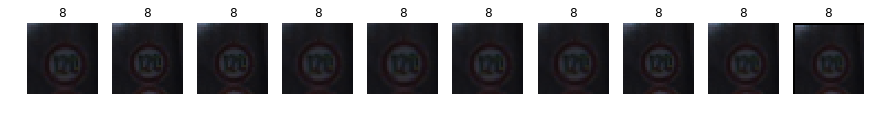

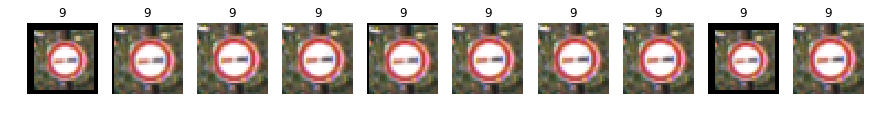

In [18]:
import Augmentor

p = Augmentor.Pipeline()
p.zoom(probability=0.8, min_factor=0.8, max_factor=1.2)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, np.full(len(labels), class_id, dtype=int))

### Rotate

I use a random of +/- 15 degree rotation to simulate signs that appear slightly rotated.

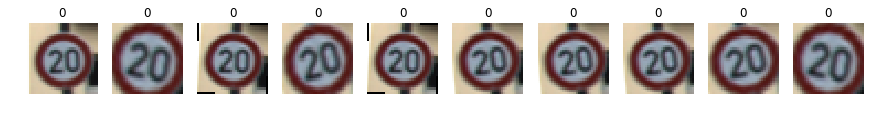

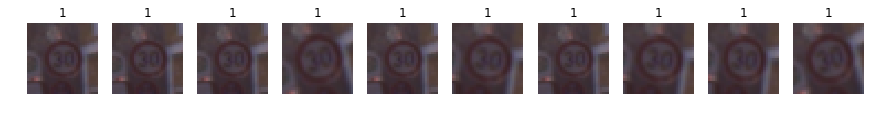

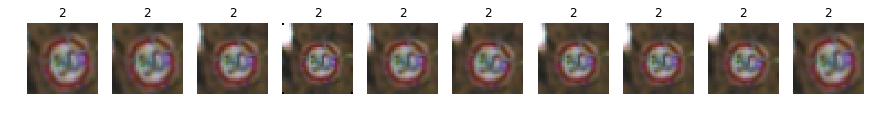

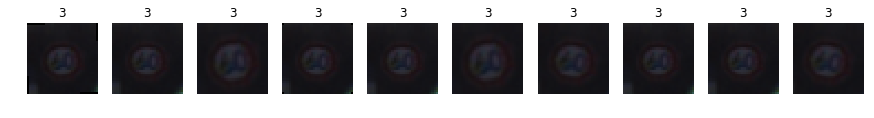

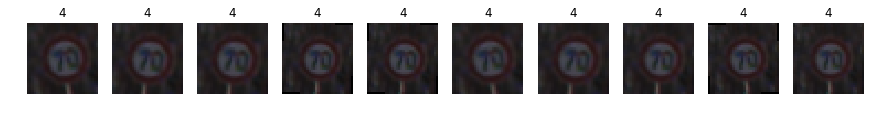

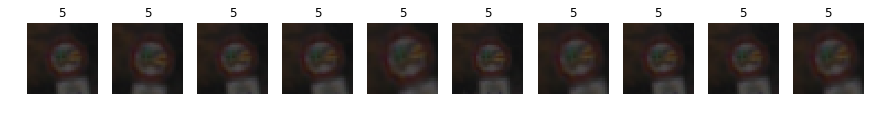

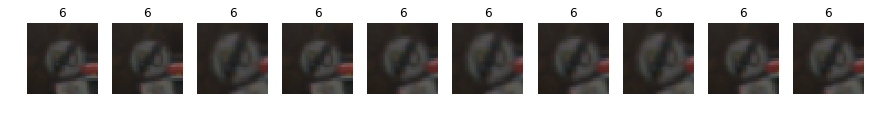

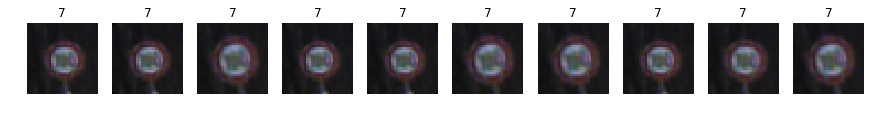

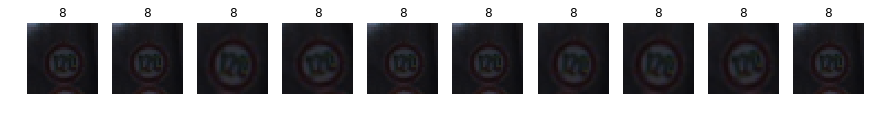

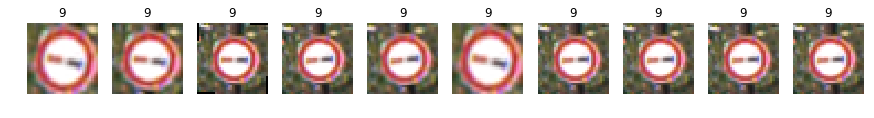

In [32]:
p = Augmentor.Pipeline()
p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, np.full(len(labels), class_id, dtype=int))

### Skew

I use a random horizontal respectively vertical tilt to simulate different camera perspectives on traffic signs.

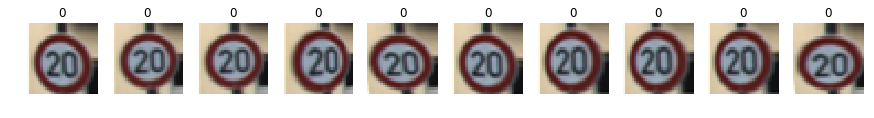

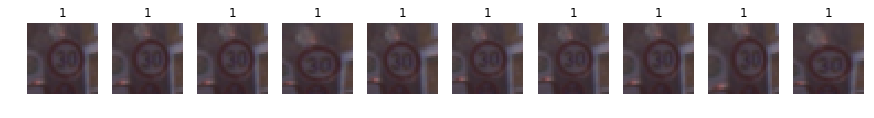

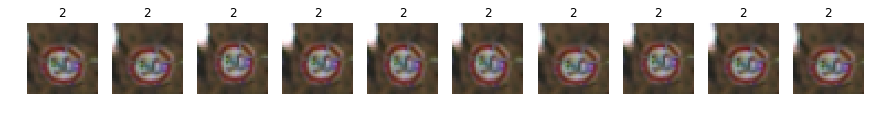

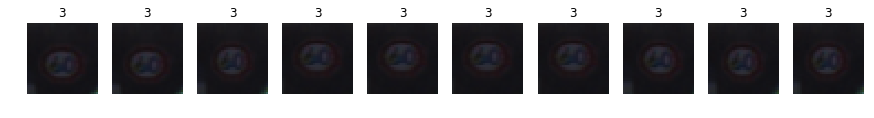

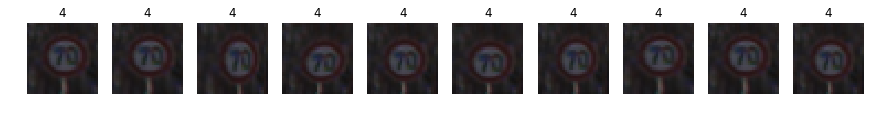

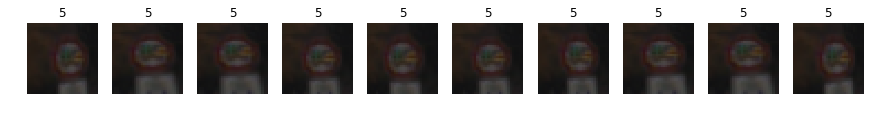

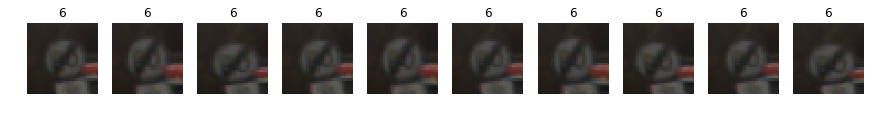

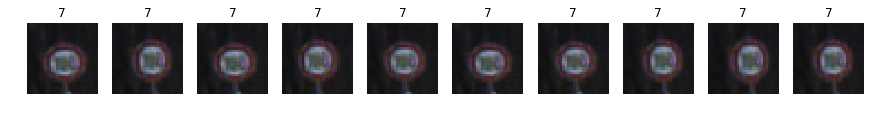

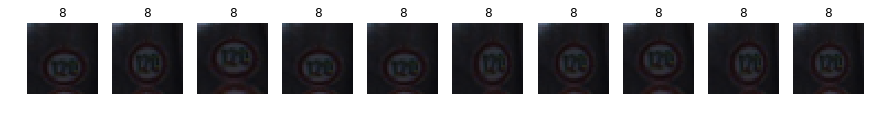

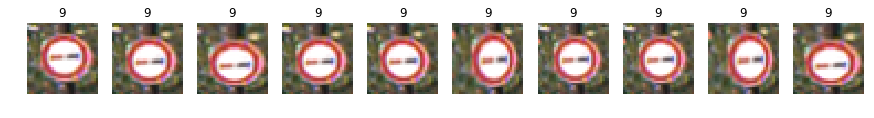

In [35]:
p = Augmentor.Pipeline()
p.skew(probability=0.8, magnitude=0.2)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, np.full(len(labels), class_id, dtype=int))

#### Final Augmentation Pipeline

The final augmentation pipeline for this project combines the three augmentation methods described above.

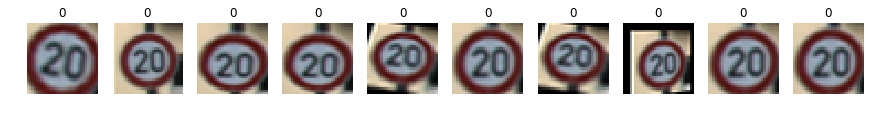

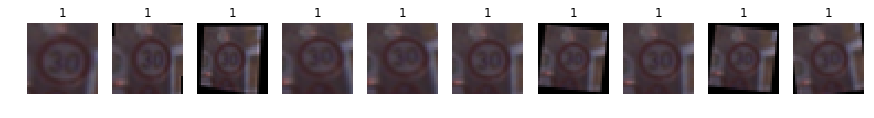

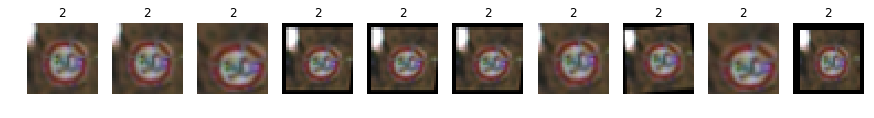

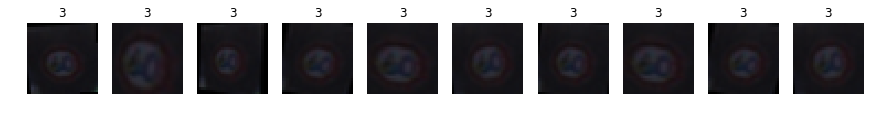

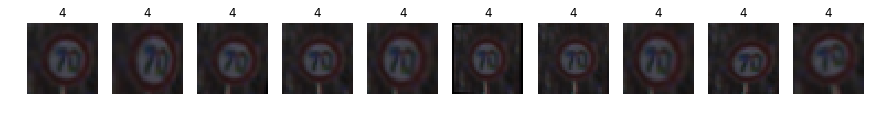

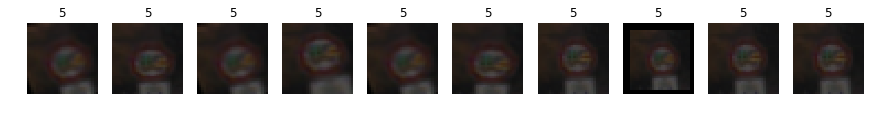

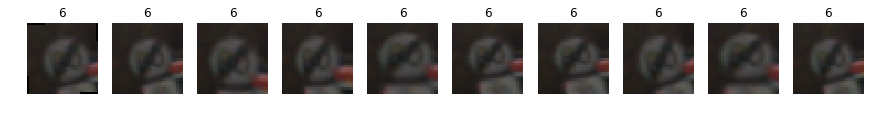

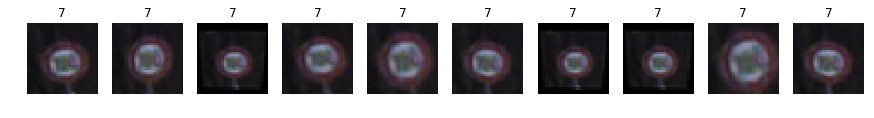

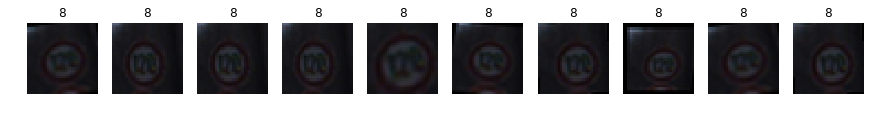

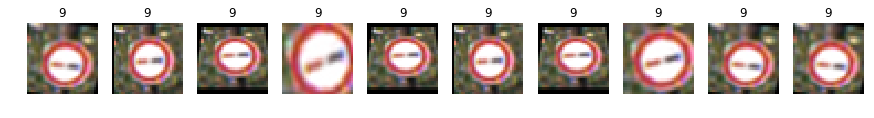

In [13]:
import Augmentor

p = Augmentor.Pipeline()
p.zoom(probability=0.8, min_factor=0.8, max_factor=1.2)
p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)
p.skew(probability=0.8, magnitude=0.2)

for class_id in range(0, 10):
    y = np.nonzero(y_train == class_id)[0]
    x = X_train[y_train == class_id]

    datagen = p.keras_generator_from_array([x[0]], [class_id], batch_size=10)
    images, labels = next(datagen)
    show_dataset(images, labels, np.full(len(labels), class_id, dtype=int))

----

## Step 4: Design and Test a Model Architecture

Goal of the project is to design and train a model that achieves an accuracy of 93% or greater, on the validation set. 
In this step, I designed and tested a model architecture to achieve this goal.

Since I'm already familiar with Keras and love the streamlined API of Keras, I decided to create the project with Keras and Tesorflow as the backend.


**Optimization Method**

The following method allows to change the optimization method very easy. So the network architecture can be easy testet with different optimization methods to choose the best one.

In [14]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

def get_optimizer(optimizer_method):
    if optimizer_method == "sdg":
        return SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if optimizer_method == "rmsprop":
        return RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    if optimizer_method == "adam":
        return Adam(lr=0.001, decay=0.001 / num_epochs)
        # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    if optimizer_method == "adagrad":
        return Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
    if optimizer_method == "adadelta":
        return Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

Using TensorFlow backend.


**Callback Methods**

I use three callback methods:

* EarlyStopping: Stops the training process prematurely if no improvement has been achieved for several consecutive epochs.

* ModelCheckpoint:
Saves the best model ever learned after each epoch.

* ReduceLROnPlateau:
Automatically reduces the learning rate if no improvement has been achieved over several epochs.

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, ProgbarLogger

def get_callbacks(model_architecture, optimizer_method):
    model_filepath = './output/traffic_signs_model_{}_{}.h5'.format(model_architecture, optimizer_method)
    callbacks = [
        EarlyStopping(monitor='loss', min_delta=0, patience=5, mode='auto', verbose=1),
        ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0,
                          min_lr=0)]
    return callbacks

Helper method to create and save a picture of the training history after the training process.

In [16]:
def plot_train_history(H, model_architecture, optimizer_method):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, len(H.history["acc"])), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, len(H.history["val_acc"])), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig('./output/training-loss-and-accuracy_{}_{}.png'.format(model_architecture, optimizer_method))
    plt.show()

Here I normalize the images between 0.0 and 1.0. The image data should be normalized so that the data has mean zero and equal variance. I only do this for the validation data, because the image augmentor we use for the training data already supplies normalized data.

Also the class labels `y_train` and `y_valid` must be converted to one hot labels.

In [17]:
import keras

# normalize data between 0.0 and 1.0
# don't normalize X_train, because this is already done by the augmentation
X_valid = X_valid.astype('float32') / 255

# convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

Here I configure the hyperparameter for the training, these are the batch size, the maximum number of epochs and the optimization method. 

I tried the three optimization methods `sdg`, `adam` and `rmsprop`. With `rmsprop` I got significant better results than with the others, so I finally use the `rmsprop` optimization method.

In [18]:
# hyperparameter for training
optimizer_method = 'rmsprop'
batch_size = 128
num_epochs = 100

### LeNet Architecture

LeNet-5 is a convolutional network designed for handwritten and machine-printed character recognition. It was introduced by the [Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun) in his paper [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) in 1998. We can also use the LeNet architecture to classify traffic signs.

LeNet Architecture:
![LeNet Architecture](examples/LeNet-architecture.png)

All we need is to change the input shape from (32, 32) to (32, 32, 3) because we use color images instead of grayscale images. Also the output size must be changed from 10 to 43 classes. 

In [19]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

# LeNet model architecture
class LeNet:
    @staticmethod
    def build(num_classes):
        model = Sequential()

        # Layer 1
        # Conv Layer 1 => 28x28x6
        model.add(Conv2D(filters=6, kernel_size=5, strides=1, activation='relu', input_shape=(32, 32, 3)))

        # Layer 2
        # Pooling Layer 1 => 14x14x6
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Layer 3
        # Conv Layer 2 => 10x10x16
        model.add(Conv2D(filters=16, kernel_size=5, strides=1, activation='relu', input_shape=(14, 14, 6)))

        # Layer 4
        # Pooling Layer 2 => 5x5x16
        model.add(MaxPooling2D(pool_size=2, strides=2))

        # Flatten
        model.add(Flatten())

        # Layer 5
        # Fully connected layer 1 => 120x1
        model.add(Dense(units=120, activation='relu'))

        model.add(Dropout(0.5))

        # Layer 6
        # Fully connected layer 2 => 84x1
        model.add(Dense(units=84, activation='relu'))

        model.add(Dropout(0.5))

        # Output Layer => num_classes x 1
        model.add(Dense(units=num_classes, activation='softmax'))

        # show and return the constructed network architecture
        model.summary()
        return model

**Train LeNet Model**

The `fit_generator()` method uses the data generator `datagen` created by the augmentation pipeline `p`, this provides newly augmented images for each batch. `fit_generator()` also shuffles the dataset by default. After training the training history will be drawn and saved in a diagram. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
__________

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 36/100
 - 9s - loss: 0.5782 - acc: 0.8191 - val_loss: 0.3677 - val_acc: 0.8943

Epoch 00036: val_loss improved from 0.39198 to 0.36768, saving model to ./output/traffic_signs_model_lenet_rmsprop.h5
Epoch 37/100
 - 9s - loss: 0.5701 - acc: 0.8249 - val_loss: 0.3718 - val_acc: 0.8907

Epoch 00037: val_loss did not improve from 0.36768
Epoch 38/100
 - 9s - loss: 0.5672 - acc: 0.8270 - val_loss: 0.3765 - val_acc: 0.8943

Epoch 00038: val_loss did not improve from 0.36768
Epoch 39/100
 - 9s - loss: 0.5496 - acc: 0.8339 - val_loss: 0.3723 - val_acc: 0.8941

Epoch 00039: val_loss did not improve from 0.36768
Epoch 40/100
 - 9s - loss: 0.5598 - acc: 0.8307 - val_loss: 0.3646 - val_acc: 0.8993

Epoch 00040: val_loss improved from 0.36768 to 0.36456, saving model to ./output/traffic_signs_model_lenet_rmsprop.h5
Epoch 41/100
 - 9s - loss: 0.5586 - acc: 0.8283 - val_loss: 0.3797 - val_acc: 0.8939

Epoch 00041: v

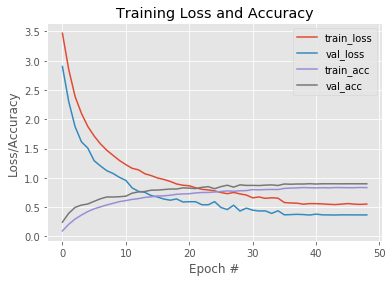

In [20]:
model_architecture = 'lenet'

# image augmentation
datagen = p.keras_generator_from_array(X_train, y_train, batch_size=batch_size)

# build LeNet model
lenet_model = LeNet.build(num_classes)

# the function to optimize is the cross entropy between the true label and the output (softmax) of the model
lenet_model.compile(optimizer=get_optimizer(optimizer_method), loss='categorical_crossentropy', metrics=['accuracy'])

# train model
H = lenet_model.fit_generator(datagen,
                              validation_data=(X_valid, y_valid),
                              steps_per_epoch=len(X_train) / batch_size,
                              callbacks=get_callbacks(model_architecture, optimizer_method),
                              epochs=num_epochs,
                              verbose=2)

# plot and save the training loss and accuracy
plot_train_history(H, model_architecture, optimizer_method)

We reached a maximum **validation accuracy of 89.84%**. From about epoch 30, there has hardly been an improvement.

**Evaluate LeNet Model**

Here I evaluate the trained LeNet model against the test data `X_test`and `y_test`. The test data are also data from the german traffic sing dataset, but the network has never seen it before. 

The evaluation calculates the loss and accuracy of the trained model. In addition, some test records are listed with their ground truth labels and predicted labels.

In [22]:
from keras.models import load_model

model_architecture = 'lenet'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

# convert class vector to binary class matrix.
y_test = keras.utils.to_categorical(y_test, num_classes)

# normalize data between 0.0 and 1.0
X_test = X_test.astype('float32') / 255

# load trained model
lenet_model = load_model('./output/traffic_signs_model_{}_{}.h5'.format(model_architecture, optimizer_method))
print()
# print loss and accuracy of the trained model
loss, acc = lenet_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('Loss:     {:.2f}%'.format(loss * 100))
print('Accuracy: {:.2f}%'.format(acc * 100))
print()

# show the true and the predicted classes for a couple of items of the test dataset
y_pred = lenet_model.predict(X_test)

start = 110
count = 20
for i, (y_t, y_p) in enumerate(zip(y_test[start:start + count], y_pred[start:start + count])):
    print("{:4d} : True={: <2}  Predicted={: <2}  {}"
          .format(i + start, y_t.argmax(axis=-1), y_p.argmax(axis=-1),
                  y_t.argmax(axis=-1) == y_p.argmax(axis=-1)))


Loss:     47.95%
Accuracy: 86.62%

 110 : True=1   Predicted=1   True
 111 : True=14  Predicted=14  True
 112 : True=16  Predicted=16  True
 113 : True=10  Predicted=10  True
 114 : True=30  Predicted=20  False
 115 : True=3   Predicted=3   True
 116 : True=27  Predicted=27  True
 117 : True=29  Predicted=29  True
 118 : True=1   Predicted=1   True
 119 : True=17  Predicted=15  False
 120 : True=13  Predicted=13  True
 121 : True=7   Predicted=7   True
 122 : True=1   Predicted=4   False
 123 : True=8   Predicted=8   True
 124 : True=2   Predicted=2   True
 125 : True=10  Predicted=10  True
 126 : True=10  Predicted=10  True
 127 : True=30  Predicted=20  False
 128 : True=1   Predicted=1   True
 129 : True=6   Predicted=6   True


The evaluation of the LeNet model with the test data resulted in a **test accuracy of 86.62%**.

The result is not bad, but the goal of a minimum accuracy of 93% is not reached!

### MiniVGGNet Architecture

The VGG network architecture was introduced by Simonyan and Zisserman in their 2014 paper, [Very Deep Convolutional Networks for Large Scale Image Recognition](https://arxiv.org/abs/1409.1556). It is one of the highest performing Convolutional Neural Networks on the [ImageNet challenge](http://image-net.org/challenges/LSVRC/) over the past few years.

VGGNet Architecture:
![VGGNet Architecture](examples/VGG-16-Model-Architecture.png.jpg)

This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers, each with 4,096 nodes are then followed by a softmax classifier.

In order to improve the weak result obtained with the LeNet model, I use a variant of the VGGNet Architecture from the book [Deep Learning for Computer Vision](https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/) of [Adrian Rosebrock](https://www.pyimagesearch.com/author/adrian/), called MiniVGNet.

MiniVGGNet Arichteture:
![MiniVGGNet Architecture](examples/MiniVGGNet-Architecture.png.jpg)

To use the MiniVGGNet architecture described above for traffic sign classification the size of the last fully connected layer must be changed from 10 to 43 classes.

In [23]:
from keras.layers import Activation, BatchNormalization

class MiniVGGNet:
    @staticmethod
    def build(num_classes):
        model = Sequential()

        chanDim = -1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 3)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(num_classes))
        model.add(Activation("softmax"))

        # show and return the constructed network architecture
        model.summary()
        return model


**Train MiniVGGNet Model**

The trainig process is the same as decribed above, only the model construction changed from LeNet to MiniVGGNet model. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
__________

Epoch 00030: val_loss did not improve from 0.13865
Epoch 31/100
 - 10s - loss: 0.0114 - acc: 0.9961 - val_loss: 0.1452 - val_acc: 0.9719

Epoch 00031: val_loss did not improve from 0.13865
Epoch 32/100
 - 10s - loss: 0.0094 - acc: 0.9972 - val_loss: 0.1321 - val_acc: 0.9721

Epoch 00032: val_loss improved from 0.13865 to 0.13207, saving model to ./output/traffic_signs_model_vggnet_rmsprop.h5
Epoch 33/100
 - 10s - loss: 0.0069 - acc: 0.9980 - val_loss: 0.1247 - val_acc: 0.9739

Epoch 00033: val_loss improved from 0.13207 to 0.12474, saving model to ./output/traffic_signs_model_vggnet_rmsprop.h5
Epoch 34/100
 - 10s - loss: 0.0092 - acc: 0.9968 - val_loss: 0.1297 - val_acc: 0.9741

Epoch 00034: val_loss did not improve from 0.12474
Epoch 35/100
 - 10s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.1259 - val_acc: 0.9760

Epoch 00035: val_loss did not improve from 0.12474

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 36/100
 - 10s - loss: 0.0077 - acc:

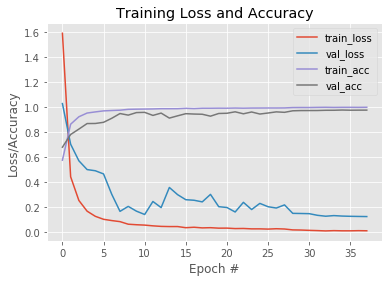

In [24]:
model_architecture = 'vggnet'

# image augmentation
datagen = p.keras_generator_from_array(X_train, y_train, batch_size=batch_size)

# build MiniVGGNet model
vggnet_model = MiniVGGNet.build(num_classes)

# the function to optimize is the cross entropy between the true label and the output (softmax) of the model
vggnet_model.compile(optimizer=get_optimizer(optimizer_method), loss='categorical_crossentropy', metrics=['accuracy'])

# train model
H = vggnet_model.fit_generator(datagen,
                               validation_data=(X_valid, y_valid),
                               steps_per_epoch=len(X_train) / batch_size,
                               callbacks=get_callbacks(model_architecture, optimizer_method),
                               epochs=num_epochs,
                               verbose=2)

# plot and save the training loss and accuracy
plot_train_history(H, model_architecture, optimizer_method)

We reached a maximum **validation accuracy of 97.60%**.

**Evaluate MiniVGGNet Model**

The evaluation is the same as already described above.

In [52]:
import keras
from keras.models import load_model

model_architecture = 'vggnet'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

# convert class vector to binary class matrix.
y_test = keras.utils.to_categorical(y_test, num_classes)

# normalize data between 0.0 and 1.0
X_test = X_test.astype('float32') / 255

# load trained model
vggnet_model = load_model('./output/traffic_signs_model_{}_{}.h5'.format(model_architecture, optimizer_method))
print()
# print loss and accuracy of the trained model
loss, acc = vggnet_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('Loss:     {:.2f}%'.format(loss * 100))
print('Accuracy: {:.2f}%'.format(acc * 100))
print()

# show the true and the predicted classes for a couple of items of the test dataset
y_pred = vggnet_model.predict(X_test)

start = 110
count = 20
for i, (y_t, y_p) in enumerate(zip(y_test[start:start + count], y_pred[start:start + count])):
    print("{:4d} : True={: <2}  Predicted={: <2}  {}"
          .format(i + start, y_t.argmax(axis=-1), y_p.argmax(axis=-1),
                  y_t.argmax(axis=-1) == y_p.argmax(axis=-1)))    


Loss:     18.31%
Accuracy: 95.46%

 110 : True=1   Predicted=1   True
 111 : True=14  Predicted=14  True
 112 : True=16  Predicted=16  True
 113 : True=10  Predicted=10  True
 114 : True=30  Predicted=23  False
 115 : True=3   Predicted=3   True
 116 : True=27  Predicted=27  True
 117 : True=29  Predicted=29  True
 118 : True=1   Predicted=1   True
 119 : True=17  Predicted=17  True
 120 : True=13  Predicted=13  True
 121 : True=7   Predicted=7   True
 122 : True=1   Predicted=1   True
 123 : True=8   Predicted=8   True
 124 : True=2   Predicted=2   True
 125 : True=10  Predicted=10  True
 126 : True=10  Predicted=10  True
 127 : True=30  Predicted=20  False
 128 : True=1   Predicted=1   True
 129 : True=6   Predicted=6   True


The evaluation of the MiniVGGNet model with the test data resulted in a **test accuracy of 95.46%**.

By further tuning the hyperparameters and improving the data preprocessing, a further improvement can be achieved, but the target of 93% was reached!

**Confusion Matrix**

A confusion matrix is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows in which cases your classification model is confused when it makes predictions.

Here is the confusion matrix of the trained MiniVGGNet model calculated with the test data set. The confusion matrix shows that the model has very few outliers.

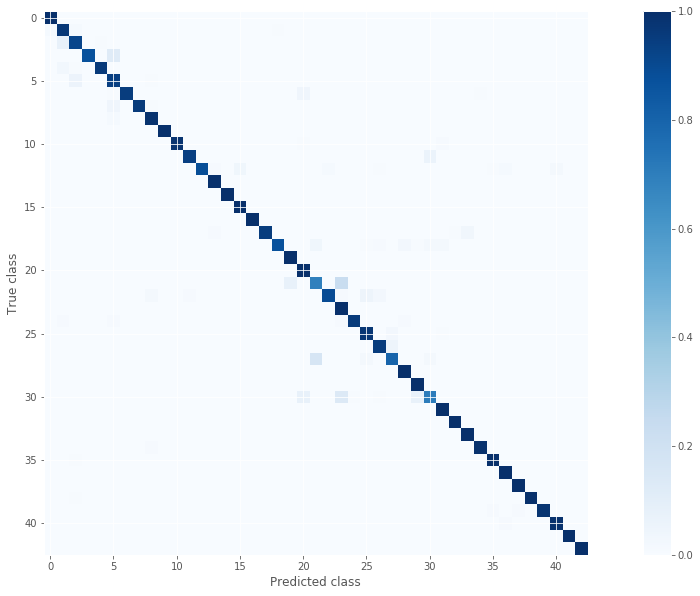

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
plt.figure(figsize=(20, 10))
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

---

## Step 5: Test the Model on New Images

In this step I test my model with some pictures of German traffic signs from the web.

### Load and Output the Images

I have collected 20 images of German traffic signs from the Internet and stored in the directory `test_images`.

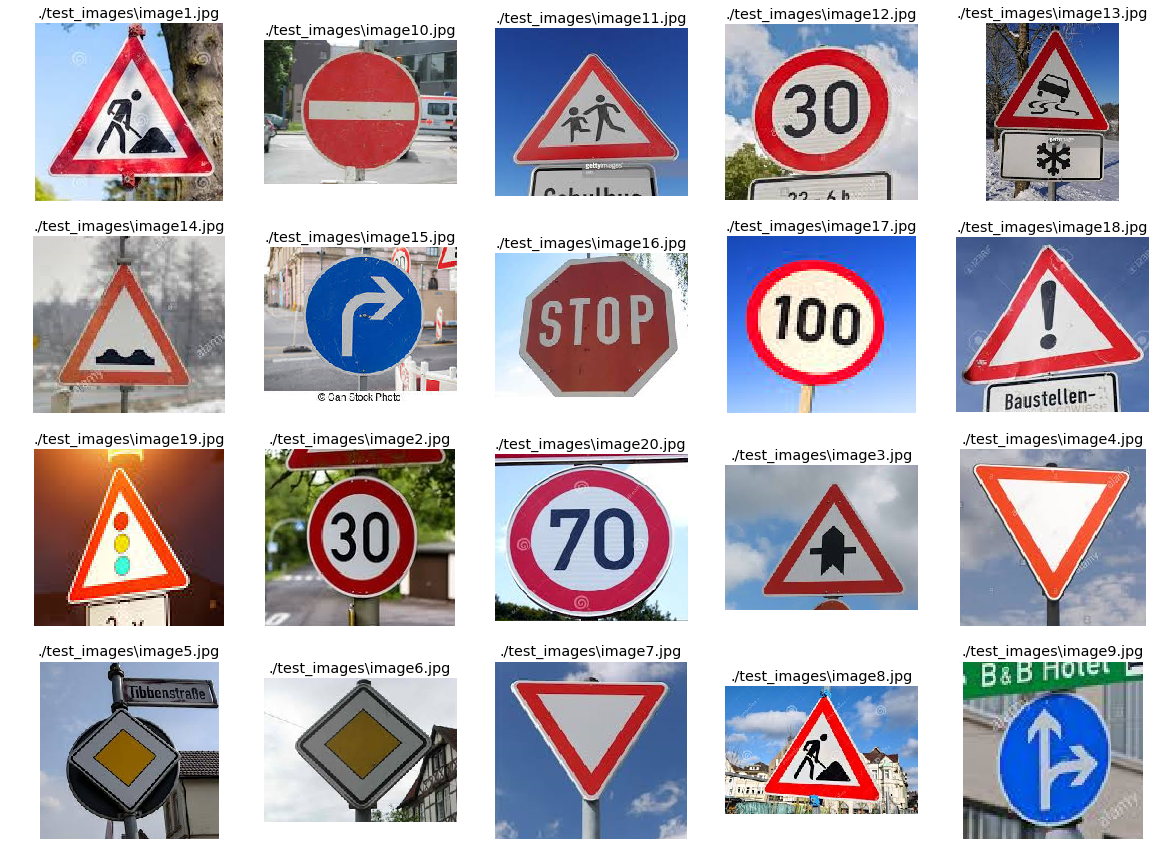

In [54]:
import glob
import cv2
    
# show test images
filenames = glob.glob('./test_images/*.jpg')
num_files = int(len(filenames))
cols = 5
rows = int(num_files / cols)
if num_files % cols > 0:
    rows += 1

fig, axs = plt.subplots(rows, cols, figsize=(20, 15))
axs = axs.ravel()

for i, filename in enumerate(filenames):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(filename)

plt.show()


### Predict the Sign Type for Each Image

Here I predict the classes for the 20 test images and output them together with the names of the traffic signs.

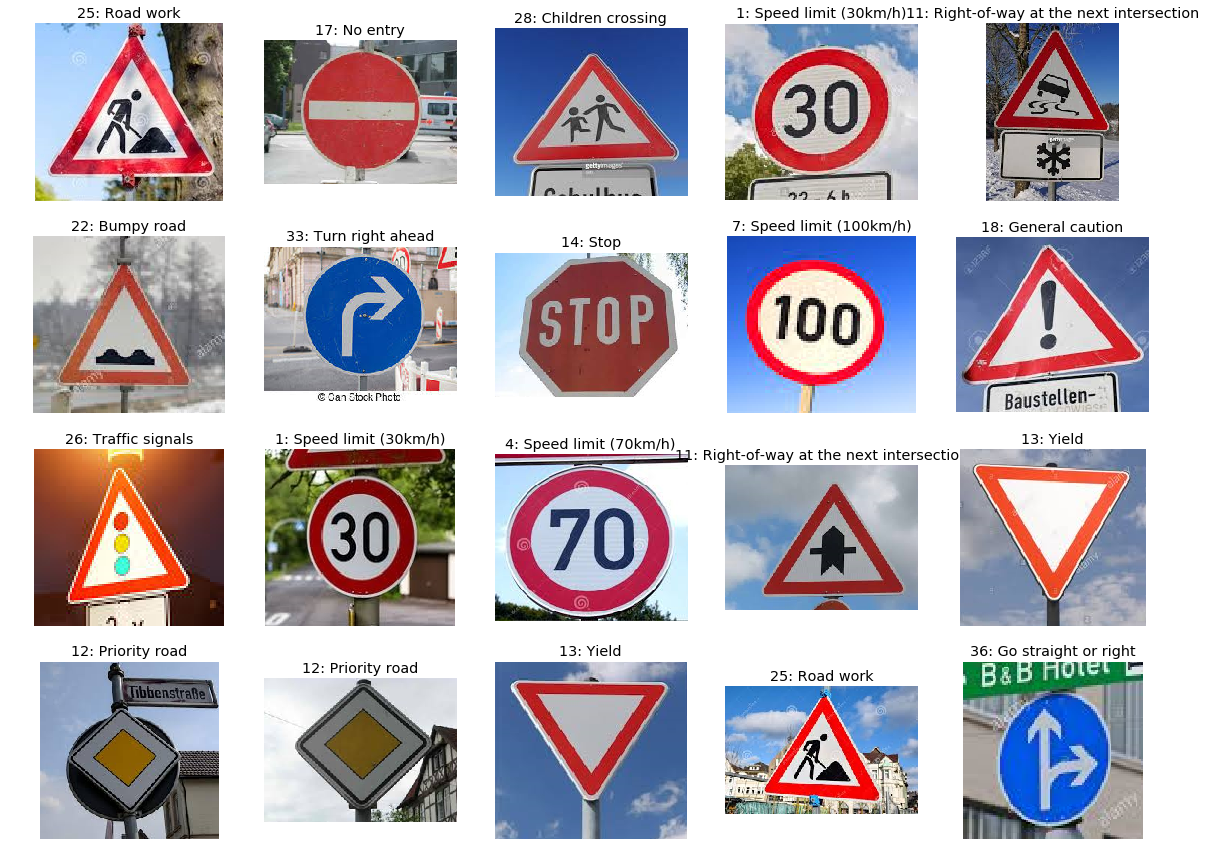

In [55]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.models import load_model

# read and preprocess test images
original_images = []
X_test = []
filenames = glob.glob('./test_images/*.jpg')
for filename in filenames:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_images.append(image)
    resized_image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
    X_test.append(resized_image)

X_test = np.array(X_test)

# normalize data between 0.0 and 1.0
X_test = X_test.astype('float32') / 255

# load trained vggnet model
model = load_model('./output/traffic_signs_model_{}_{}.h5'.format('vggnet', 'sdg'))

# predict
y_pred = model.predict(X_test)

# show test images with class predictions
num_files = int(len(filenames))
cols = 5
rows = int(num_files / cols)
if num_files % cols > 0:
    rows += 1

fig, axs = plt.subplots(rows, cols, figsize=(20, 15))
axs = axs.ravel()

for i, (filename, image, org_image) in enumerate(zip(filenames, X_test, original_images)):
    class_id = y_pred.argmax(axis=-1)[i]
    class_name = sign_names[class_id][1]
    axs[i].axis('off')
    axs[i].imshow(org_image)
    axs[i].set_title('{}: {}'.format(class_id, class_name))

plt.show()

Even when testing with new images from the Web, the trained model achieved good results. Only one of the 20 new images was classified incorrectly.

### Analyze Performance for Test Images

In [56]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

y_true = np.array([25, 17, 28, 1, 23, 22, 33, 14, 7, 18, 26, 1, 4, 11, 13, 12, 12, 13, 25, 36])
print("True:      " + str(y_true))
print("Predicted: " + str(y_pred.argmax(axis=-1)))
test_accuracy = sum(y_true == y_pred.argmax(axis=-1))/len(y_true)
print("Test Accuracy = {:.1f}%".format(test_accuracy*100))


True:      [25 17 28  1 23 22 33 14  7 18 26  1  4 11 13 12 12 13 25 36]
Predicted: [25 17 28  1 11 22 33 14  7 18 26  1  4 11 13 12 12 13 25 36]
Test Accuracy = 95.0%


With an accuracy of 95%, the above-mentioned test accuracy is reflected again!

It is noticeable that the misrecognized image should have class 23. This is one of the classes underrepresented in the training data.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). 

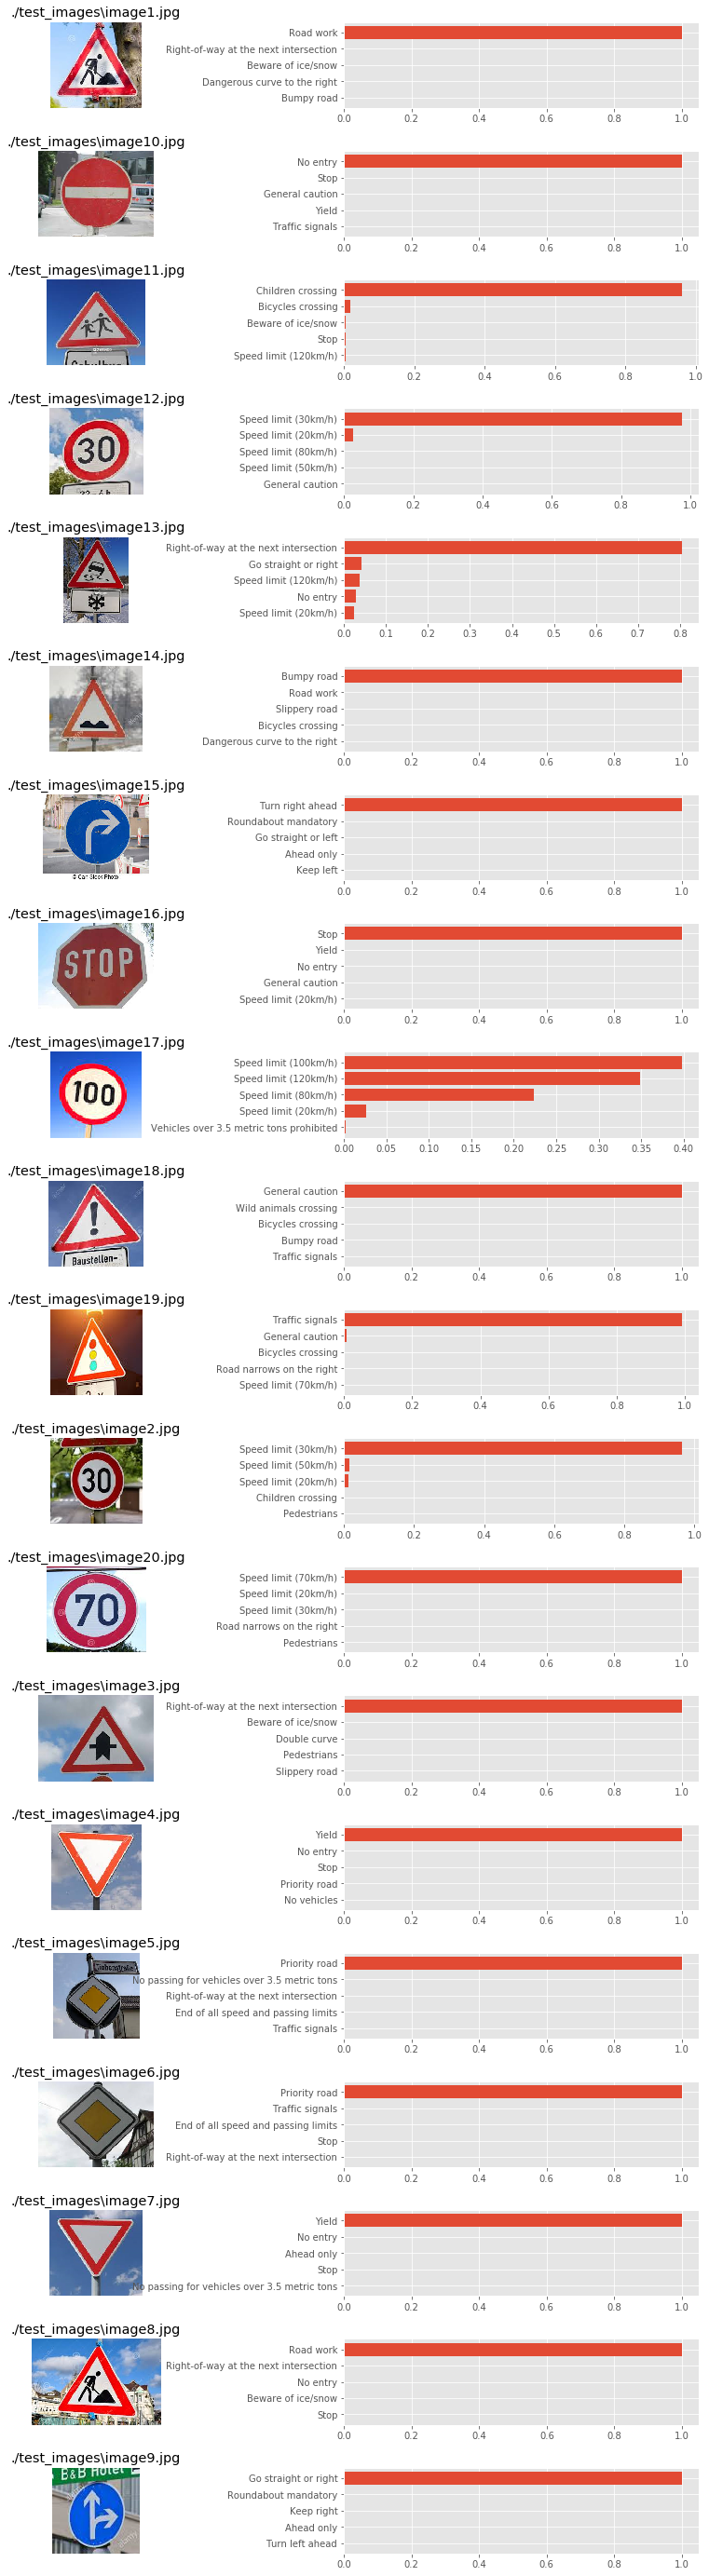

In [57]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

k = 5
n = len(filenames)
plt.figure(figsize=(15, 50))
plt.subplots_adjust(hspace=0.5)
for i, (filename, prob, org_image) in enumerate(zip(filenames, y_pred, original_images)):
    top_values_index = sorted(range(len(prob)), key=lambda p: prob[p])[-k:]
    class_id = prob.argmax(axis=-1)
    class_name = sign_names[class_id][1]
    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(original_images[i])
    plt.title(filename)
    plt.axis('off')
    plt.subplot(n, 2, 2 * i + 2)
    plt.barh(np.arange(1, 6, 1), prob[top_values_index])
    labels = np.array([sign_names[j] for j in top_values_index])
    plt.yticks(np.arange(1, 6, 1), labels[:, 1])
plt.show()


The diagram above shows that most classes are clearly recognized. Only in "Speed limit (100km/h)" the top 5 predictions are close together. But that is also because the dataset contains  of several classes that are very similar.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.


Activation map 0


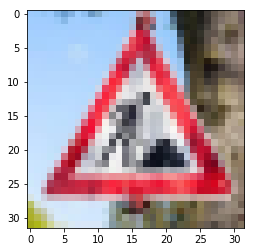

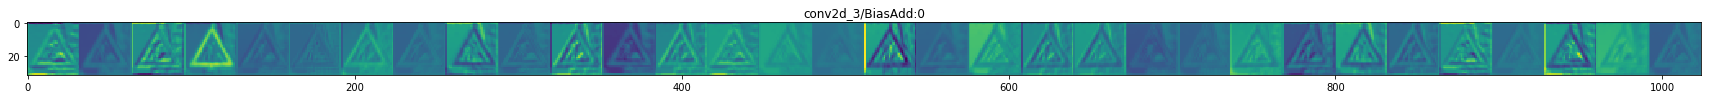

Activation map 1


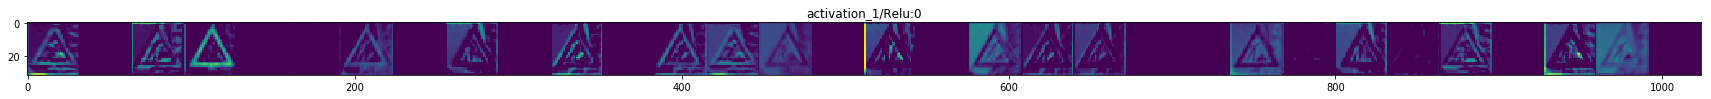

Activation map 2


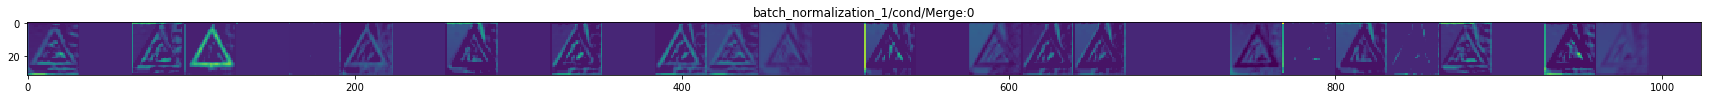

Activation map 3


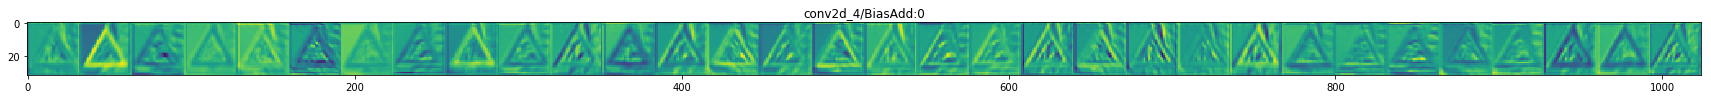

Activation map 4


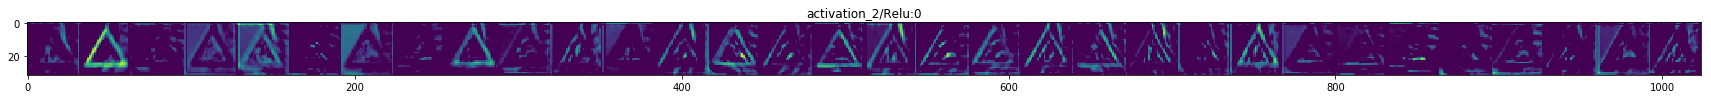

Activation map 5


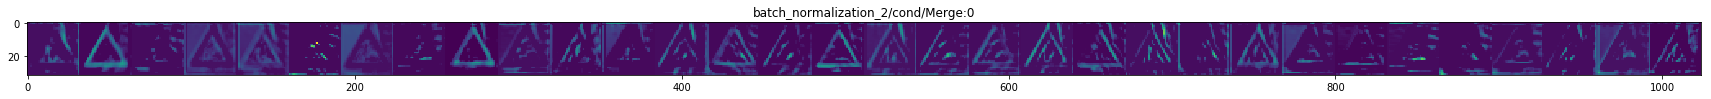

Activation map 6


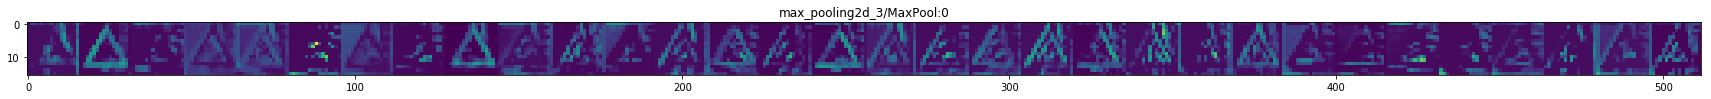

Activation map 7


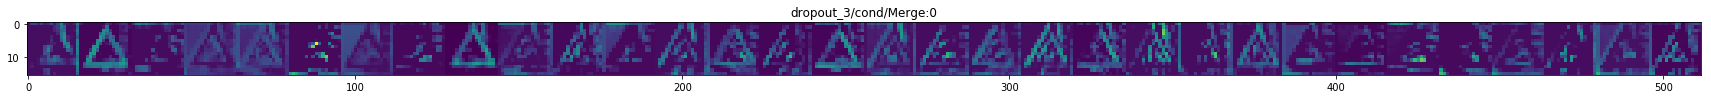

Activation map 8


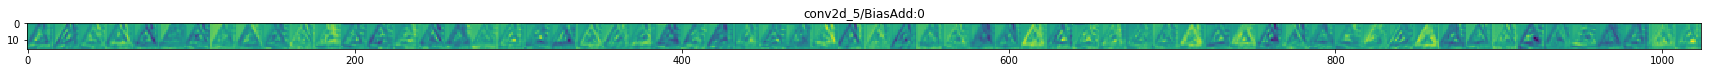

Activation map 9


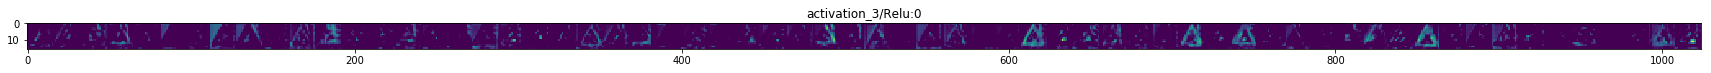

Activation map 10


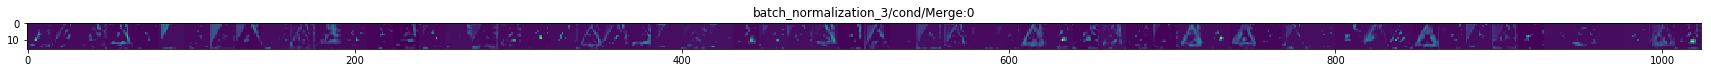

Activation map 11


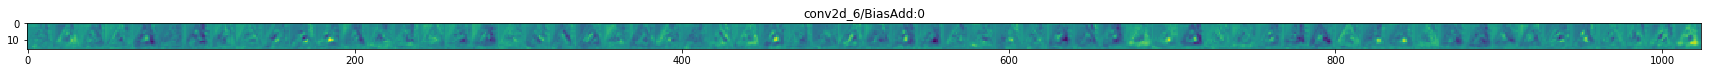

Activation map 12


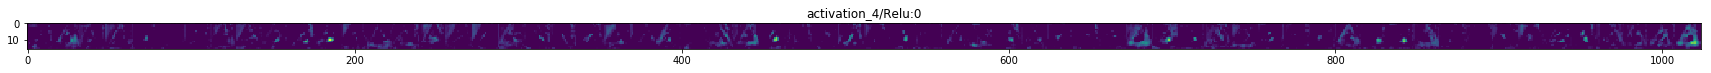

Activation map 13


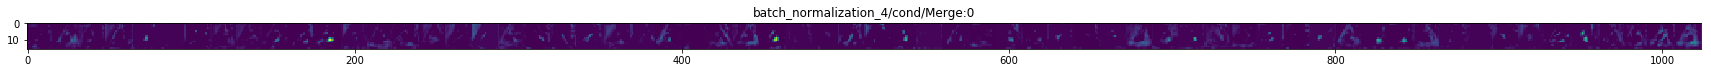

Activation map 14


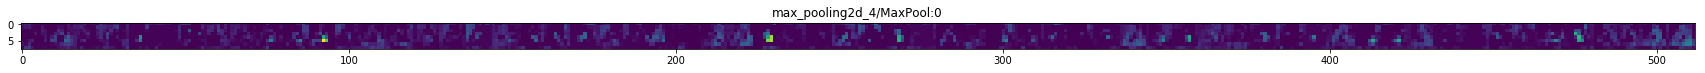

Activation map 15


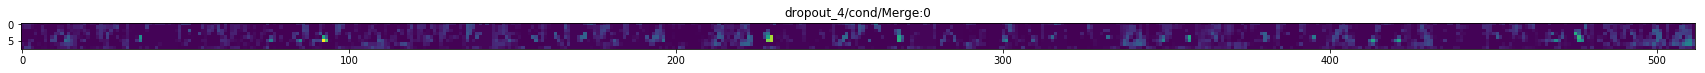

Activation map 16


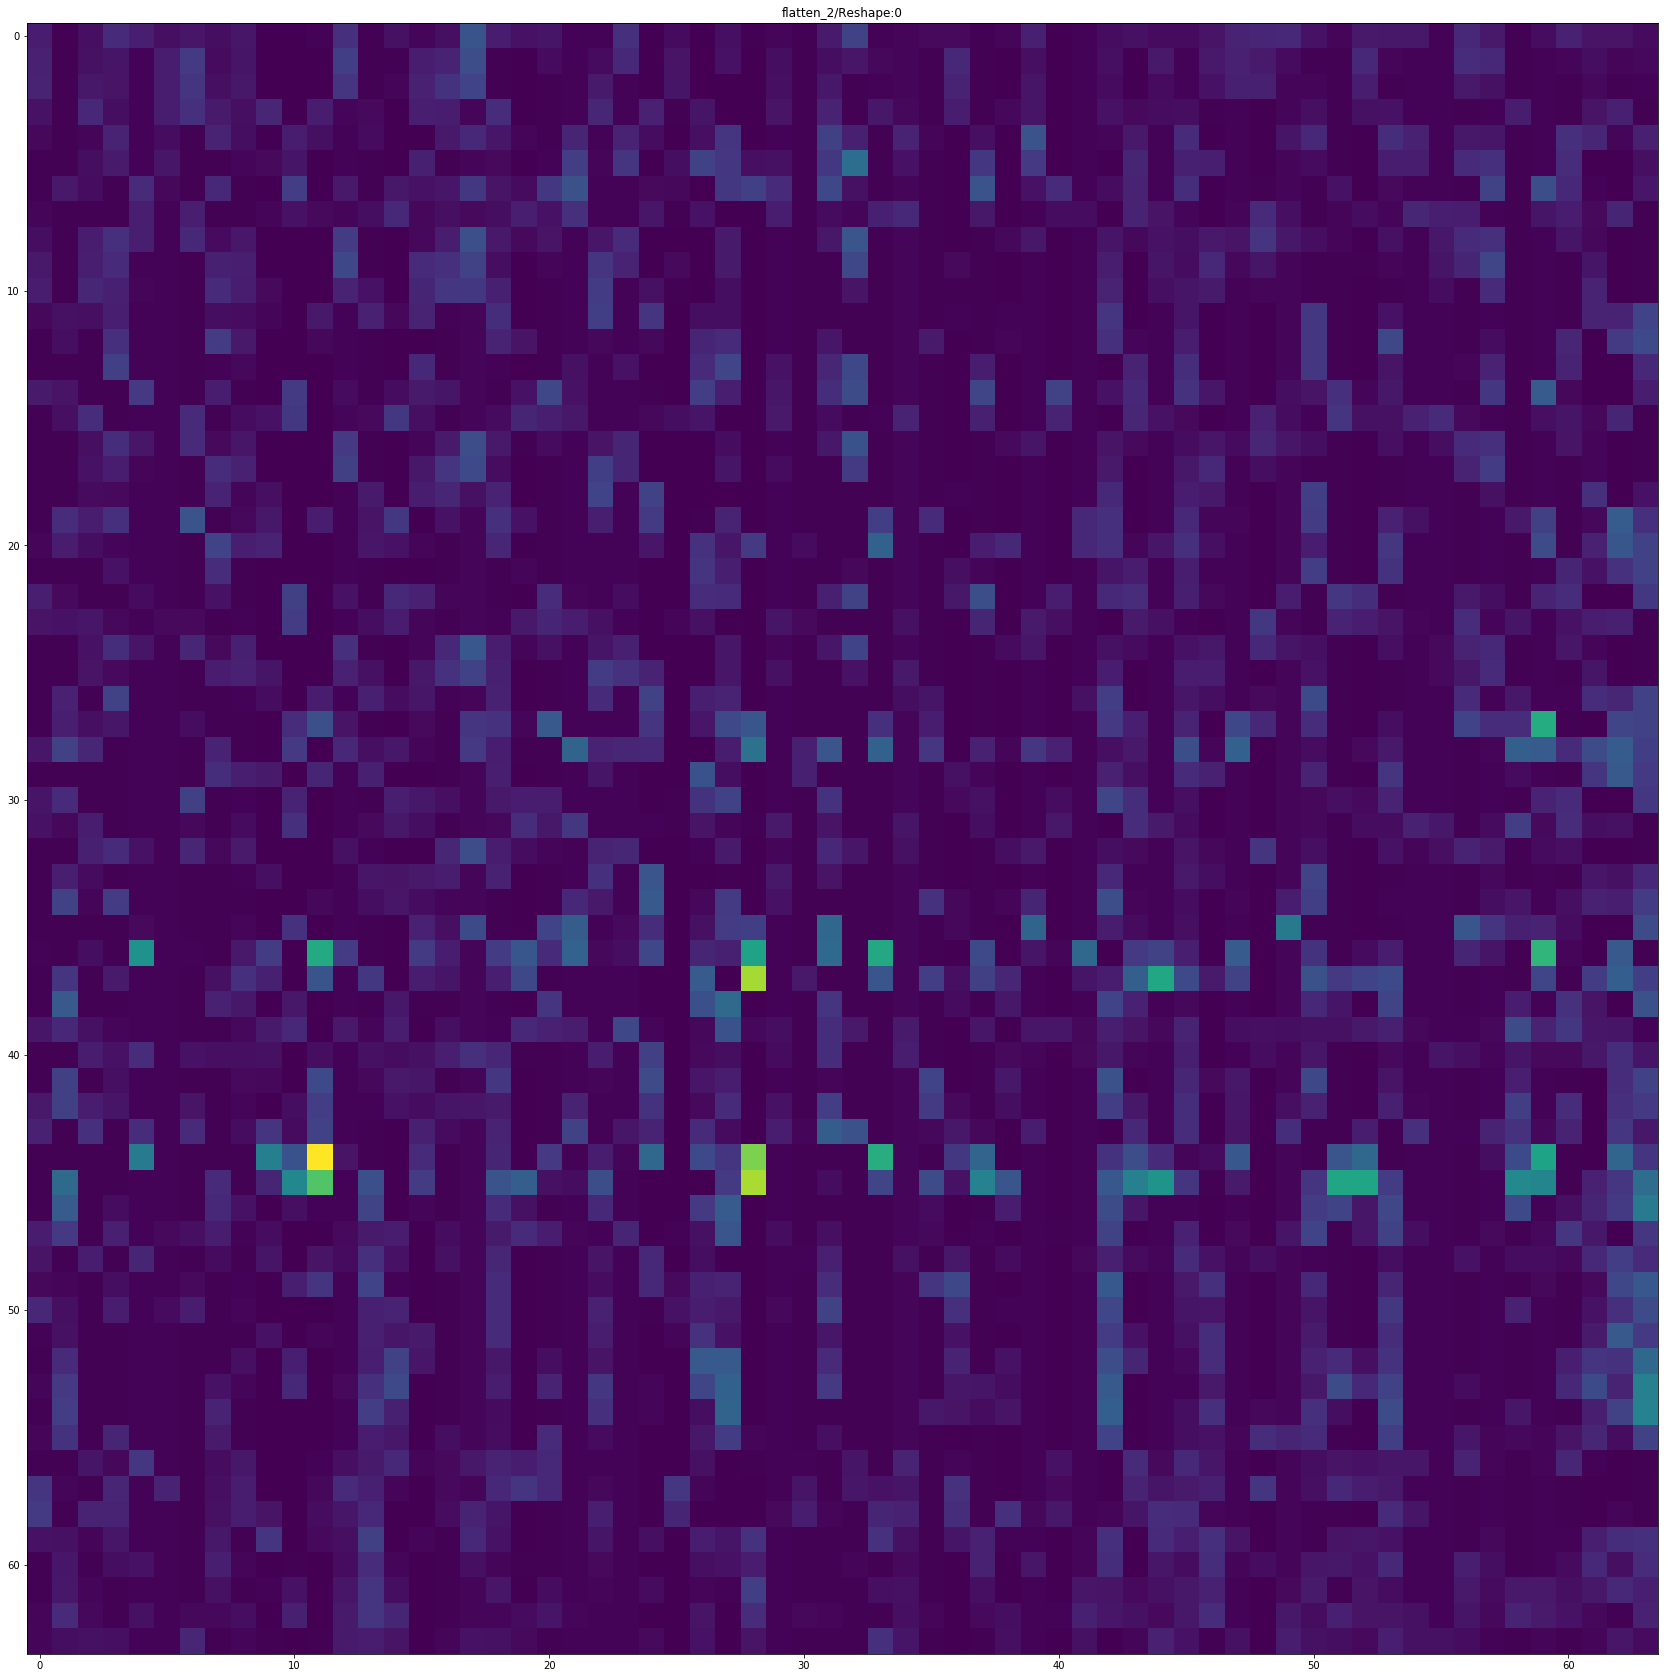

Activation map 17


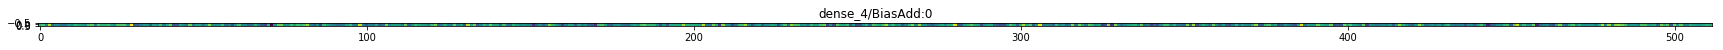

Activation map 18


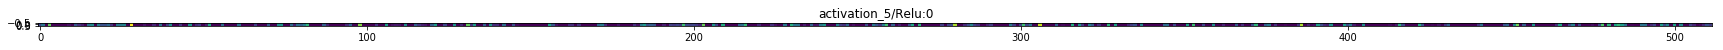

Activation map 19


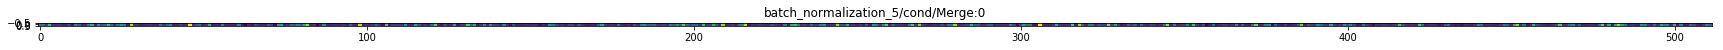

Activation map 20


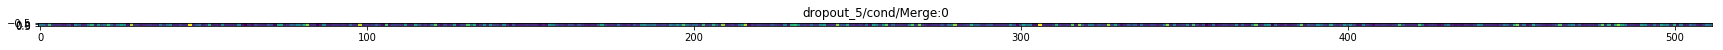

Activation map 21


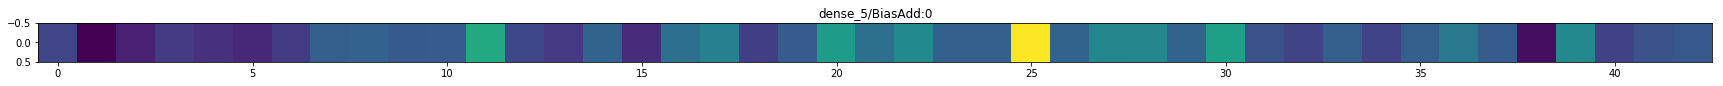

Activation map 22


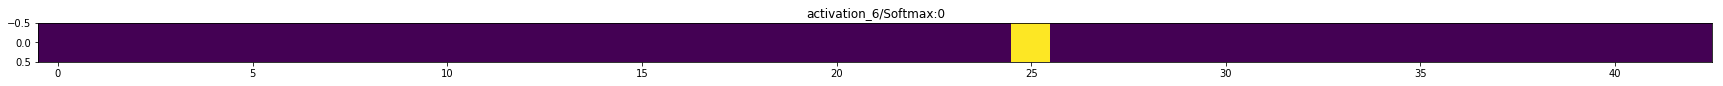

In [18]:
# https://github.com/philipperemy/keras-activations
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

def get_activations(model, model_inputs):
    outputs = [layer.output for layer in model.layers]  
    funcs = [K.function([model.input] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    list_inputs = [[model_inputs], 0.]
    activations = [func(list_inputs)[0] for func in funcs]
    layer_names = [output.name for output in outputs]
    result = dict(zip(layer_names, activations))
    return result

def display_activations(activations):
    layer_names = list(activations.keys())
    activation_maps = list(activations.values())
    batch_size = activation_maps[0].shape[0]
    
    for i, activation_map in enumerate(activation_maps):
        print('Activation map {}'.format(i))
        shape = activation_map.shape
        
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)

            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')

        fig, ax = plt.subplots(figsize=(30, 30))
        plt.title(layer_names[i])
        ax.imshow(activations, interpolation='None', cmap='viridis')
        plt.show()
        
        
# image to visualize
test_image = X_test[0]

plt.imshow(test_image)        
activations = get_activations(model, test_image)
display_activations(activations)